In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['SimSun']
# 读取数据
data_path = r'D:\My pythoin\Kaggle\Short-term solar power forecasting\Data\test (1).csv'
df = pd.read_csv(data_path)
# 去掉相关系数低的列
low_correlation_columns = ['Weather_Relative_Humidity','Wind_Direction','Weather_Daily_Rainfall',]
df.drop(columns=low_correlation_columns, inplace=True)
print(df.describe())  # 查看数据描述
print(df.head())    # 查看数据内容
# 检测缺失值
missing_values = df.isnull().sum()
print("缺失值检测：")
print(missing_values)

         Wind_Speed  Weather_Temperature_Celsius  Global_Horizontal_Radiation  \
count  17856.000000                 17856.000000                 17856.000000   
mean       2.618206                    28.389119                   288.612915   
std        1.365170                     5.968982                   384.079104   
min        0.292916                    12.919996                     1.188076   
25%        1.474459                    23.698862                     2.608257   
50%        2.485588                    27.842842                    42.609835   
75%        3.561799                    33.108260                   522.151611   
max       10.492616                    44.194740                  1413.021729   

       Diffuse_Horizontal_Radiation  Radiation_Global_Tilted  \
count                  17856.000000             17856.000000   
mean                      97.358370               153.134398   
std                      136.624236               260.930796   
min           

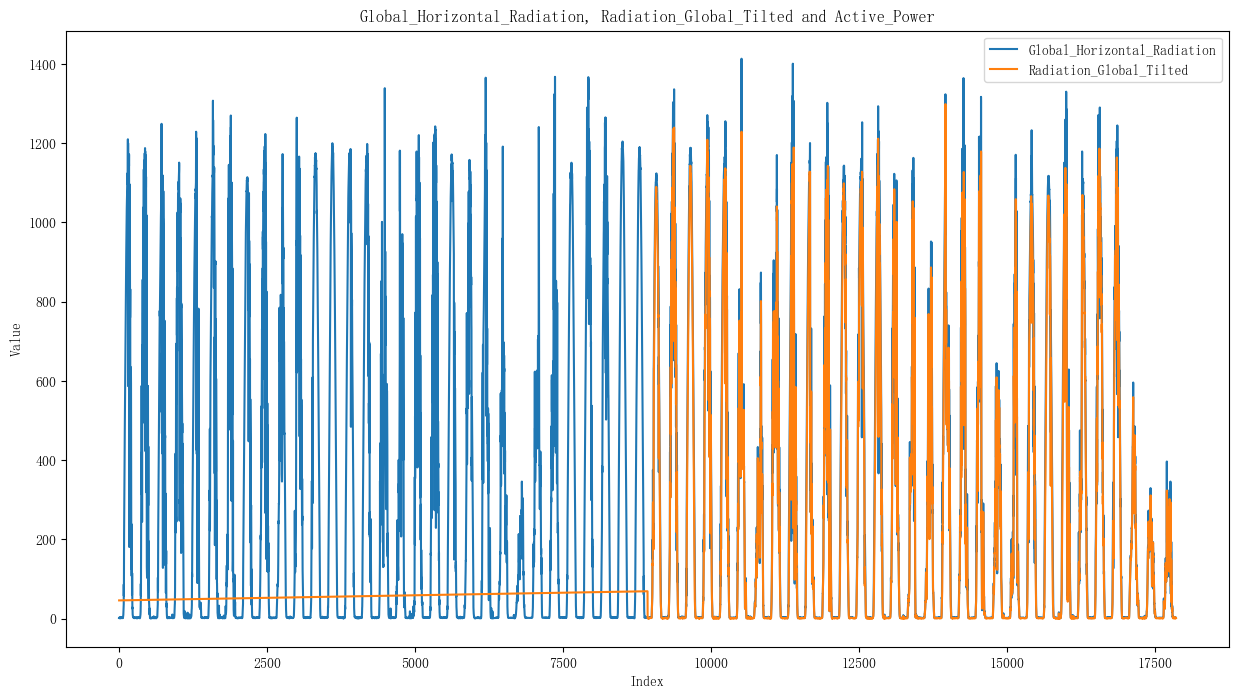

异常值填补：
Wind_Speed 异常值已填补
Weather_Temperature_Celsius 异常值已填补
Global_Horizontal_Radiation 异常值已填补
Diffuse_Horizontal_Radiation 异常值已填补
Radiation_Global_Tilted 异常值已填补
Radiation_Diffuse_Tilted 异常值已填补


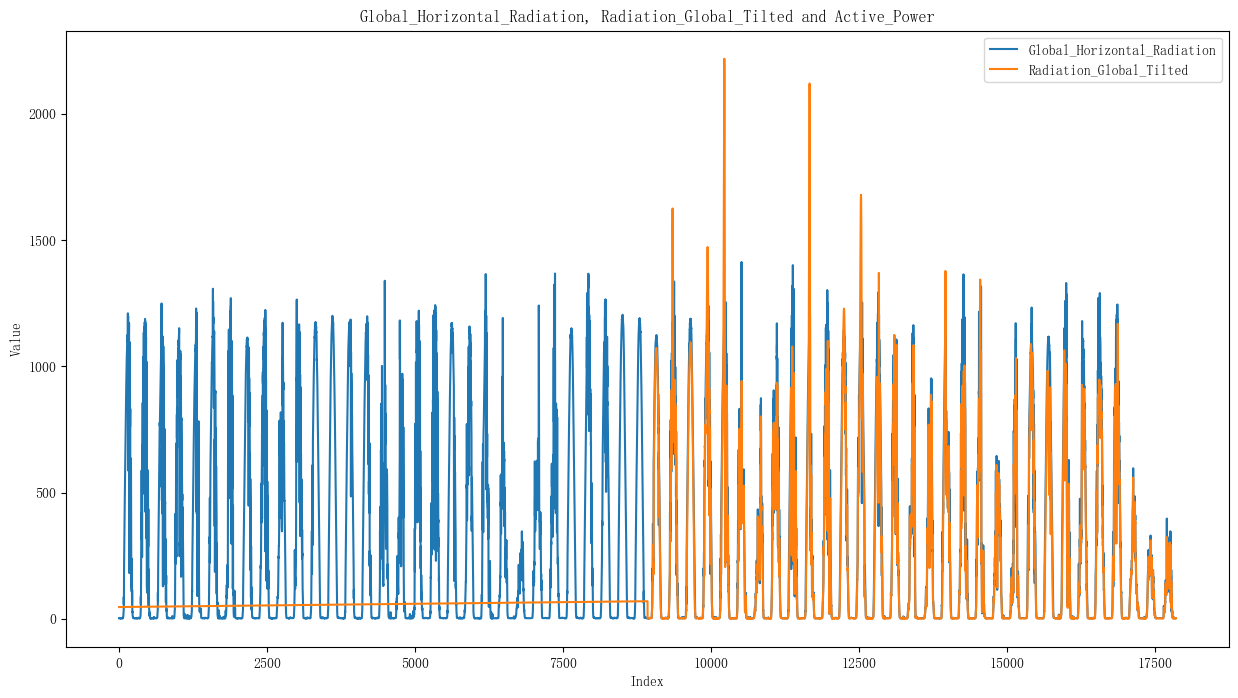

In [7]:
# 定义绘制三条曲线的函数
def plot_three_curves(df, start=0, end=1000):
    plt.figure(figsize=(15, 8))
    plt.plot(df['Global_Horizontal_Radiation'][start:end], label='Global_Horizontal_Radiation')
    plt.plot(df['Radiation_Global_Tilted'][start:end], label='Radiation_Global_Tilted')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Global_Horizontal_Radiation, Radiation_Global_Tilted and Active_Power')
    plt.legend()
    plt.show()

# 调用绘制函数，指定绘制范围
plot_three_curves(df, start=0, end=-1)

# 检测并填补异常值（使用平均值和标准差法）
def detect_and_fill_outliers(df, column):
    mean = df[column].mean()
    std = df[column].std()
    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std
    df[column] = df[column].mask((df[column] < lower_bound) | (df[column] > upper_bound))
    df[column].interpolate(method='cubic', inplace=True)

columns_to_check = ['Wind_Speed',
       'Weather_Temperature_Celsius', 'Global_Horizontal_Radiation',
       'Diffuse_Horizontal_Radiation', 'Radiation_Global_Tilted',
       'Radiation_Diffuse_Tilted']

print("异常值填补：")
for column in columns_to_check:
    detect_and_fill_outliers(df, column)
    print(f"{column} 异常值已填补")
# 调用绘制函数，指定绘制范围
plot_three_curves(df, start=0, end=-1)

这里发现测试数据也有很多缺失值，这里不能删掉，因为上传数据需要，所以只能先将就着预测，由于训练的时候排除掉了夜晚的时候，所以这里也需要这样做，最后再把夜晚的功率赋为0

In [11]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
# 2. 每天只保留6点到19点的数据
Data_step = df[(df['timestamp'].dt.hour >= 6) & (df['timestamp'].dt.hour <= 19)]

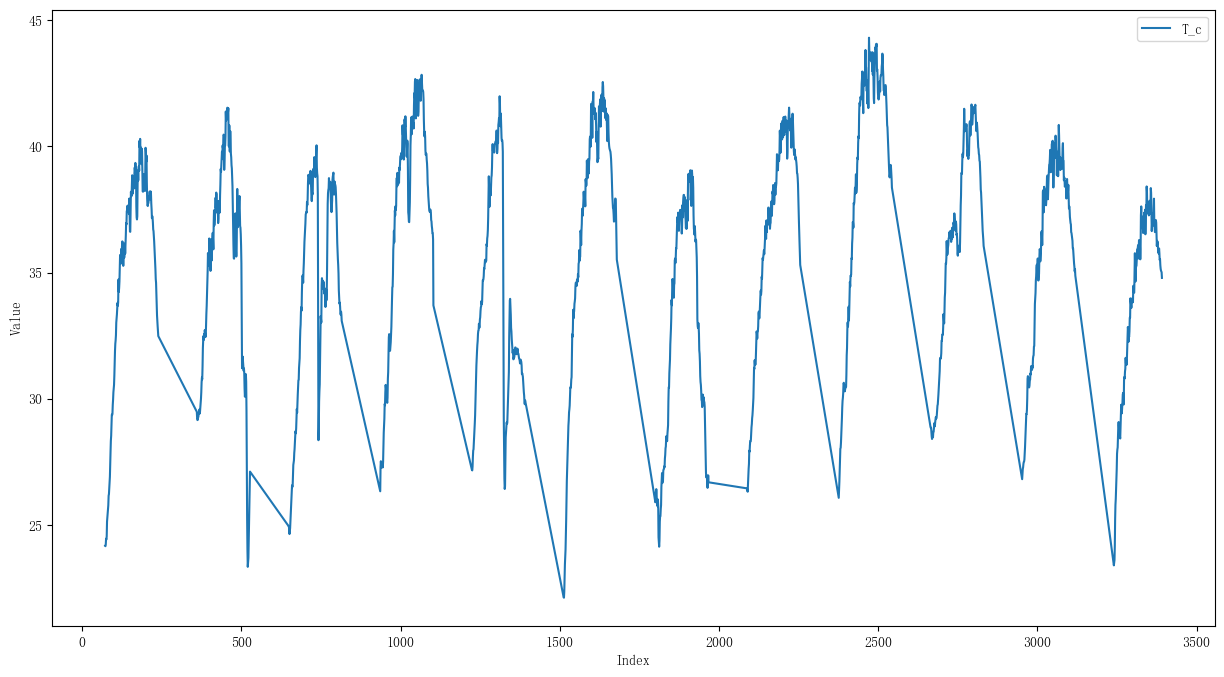

In [12]:
# 做一下特征工程
import numpy as np
# 定义常量
a = -3.23
b = -0.13
E_o = 1000
delta_T = 13
# 计算 T_c
Data_step['T_c'] = (Data_step['Radiation_Global_Tilted'] * np.exp(a + b * Data_step['Wind_Speed'])
                     + Data_step['Weather_Temperature_Celsius']) + (Data_step['Radiation_Global_Tilted'] / E_o) * delta_T
# 绘制出来看看曲线有没有用
plt.figure(figsize=(15, 8))
plt.plot(Data_step['T_c'][0:2000], label='T_c')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [18]:
# 开始训练
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.python.keras.layers import Layer

In [16]:
from sklearn.preprocessing import MinMaxScaler
# 一些参数定义
BATCH_SIZE = 128
EPOCHS = 10
SEQ_LEN = 10
FUTURE_PERIOD_PREDICT = 1
# 归一化，划分特征
def preprocess_data(dat):
    scale = MinMaxScaler().fit(dat)
    proc_dat = scale.transform(dat)

    return proc_dat,scale  # 返回的只有特征数据，不再涉及目标列
# 处理数据集（只处理特征数据）
Data_step = Data_step.drop(['timestamp'],axis = 1)
data_X,scale_test = preprocess_data(Data_step)  # 没有目标列，所以只处理特征数据

def timestamp_data(data):
    X = []
    for i in range(SEQ_LEN, len(data) - FUTURE_PERIOD_PREDICT + 1):
        X.append(data[i - SEQ_LEN:i, :])  # 含左不含右，X为特征数据
    return np.array(X)

# 处理整个数据集（无划分）
X_all = timestamp_data(data_X)

print("all data shape {0}".format(X_all.shape))

all data shape (10406, 10, 7)


326/326 [==============================] - 2s 4ms/step

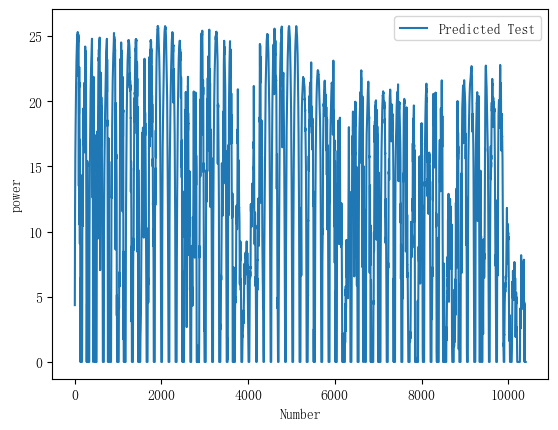

In [26]:
model_lstm_attention = tf.keras.models.load_model('GRU_Attention')
# 绘图看结果
predicted_LSTM_Att = model_lstm_attention.predict(X_all)

# 最后一步，反归一化输出
scaler_traget = MinMaxScaler(feature_range=(0, 1))
df_step3 = pd.read_csv("D:\My pythoin\Kaggle\Short-term solar power forecasting\Data\step3_data.csv")
df_step3.loc[df_step3['Active_Power'] < 0, 'Active_Power'] = 0
scaler_traget.fit_transform(np.array(df_step3['Active_Power']).reshape(-1, 1))

predictions = scaler_traget.inverse_transform(predicted_LSTM_Att.reshape(-1, 1))
plt.plot(predictions, label='Predicted Test')
plt.xlabel('Number')
plt.ylabel('power')
plt.legend()
# plt.savefig(
#     "/Users/Arithmetic/pythonProject/lstm+attention/result_pics/lstm+attention_nasdaq_epoch{0}.png".format(EPOCHS))
plt.show()

In [28]:
# print(len(Data_step['Wind_Speed']))
# # 保存结果
# np.save('D:\My pythoin\Kaggle\Short-term solar power forecasting\Data\predictions', predictions)
np.save('D:\My pythoin\Kaggle\Short-term solar power forecasting\Data\ppredicted_LSTM_Att', predicted_LSTM_Att)